## ADB: Commenti
Qui stava mischiando Tensorflow (un altro framework per deep learning) con Pytorch. Vogliamo usare SOLO pytorch, quindi ho commentato gli import di roba da Tensorflow.

In [80]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
# import tensorflow as tf
# import tensorflow.contrib.slim as slim


import math

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# from tensorflow.examples.tutorials.mnist import input_data

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

#torch.manual_seed(42)
#if cuda:
#    torch.cuda.manual_seed(42)

Using PyTorch version: 0.4.1.post2 CUDA: False


In [81]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

In [82]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


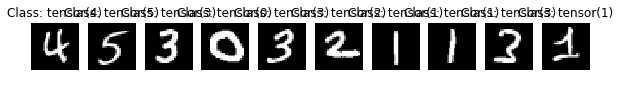

In [83]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

## ADB: Commenti
Qui ho modificato un po' la definizione della rete. Vogliamo estrarre i feature dai layer nascosti (fc1 e fc2). Quindi ho aggiunto metodi che fanno il forward() **solo** fino a un certo punto. Con questi metodi ora possiamo estrarre feature usando la rete addestrata (vede sotto in fondo). 

In [84]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)
    
    # Computes the forward activation up to fc1 output. The result of
    # calling this method on a batch of images will be a matrix of size
    # (batchsize, 128) where each ROW is the fc1 feature of the corresponding
    # input image from the batch.
    def extract_fc1(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return x

    # Computes the forward activation up to fc2 output.
    def extract_fc2(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        return x

    
model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


print(model)



Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [85]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')

In [86]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [87]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.145228
Validation set: Average loss: 0.2027, Accuracy: 9387/10000 (93%)

Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.133473
Validation set: Average loss: 0.1432, Accuracy: 9563/10000 (95%)

Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.027355
Validation set: Average loss: 0.1152, Accuracy: 9657/10000 (96%)

Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.072422
Validation set: Average loss: 0.1010, Accuracy: 9680/10000 (96%)

Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.050010
Validation set: Average loss: 0.0875, Accuracy: 9737/10000 (97%)

Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.113332
Validation set: Average loss: 0.0819, Accuracy: 9742/10000 (97%)

Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.181363
Validation set: Average loss: 0.0785, Accuracy: 9757/10000 (97%)

Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.085910
Validation set: Average loss: 0.0728, Accuracy: 9773/10000 (97%)

Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.066302
Validation set: Averag

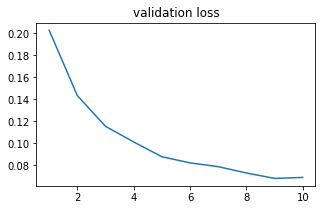

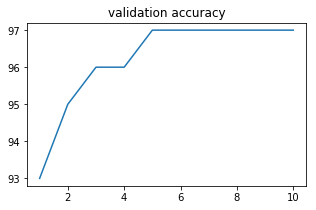

In [88]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

/home/michela/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


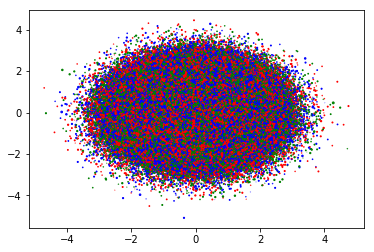

In [116]:
X = np.random.normal(0,1,fc1.shape)
Y = np.random.normal(0,1,fc2.shape)
Z = np.random.normal(0,1,labels.shape)

plt.scatter(X,Y,Z,color=['red','blue','green'])

## ADB: Commenti
Questa funzione fa l'estrazione dei feature dalla rete ormai addestrata. Scorre il dataloader del test set e raccoglie le attivazioni fc1, fc2, e le ettichette per ogni immagine. Restituisce tre tensori con questa informazione.

In [89]:
def extract_features(loader):
    model.eval()
    fc1 = []
    fc2 = []
    labels = []
    for data, target in loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        fc1.append(model.extract_fc1(data))
        fc2.append(model.extract_fc2(data))
        labels.append(target)
    return (torch.cat(fc1), torch.cat(fc2), torch.cat(labels))

In [90]:
(fc1, fc2, labels) = extract_features(validation_loader)
print(fc1.shape)
print(fc2.shape)
print(labels.shape)

torch.Size([10000, 128])
torch.Size([10000, 128])
torch.Size([10000])


## ADB: Commenti
Allora, ora siamo pronti a analizzare questi feature. Il problema con analizzare dati di questo tipo e' la alta dimensionalita' dei dati. Gia' a 128 dimensioni e' difficile capire qualcosa. Quindi vogliamo **ridurre** la dimensionalita a 2 per poter visualizzare i feature.

Possiamo provare due strategie e poi fare un confronto:

1. Applicare una technica "semplice" tipo PCA. Vede qui come fare la PCA in scikit-learn:
    http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
2. Applicare t-SNE (obbiettivo finale). Vede quiL
    http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Per tutte e due queste tecniche, si fa la stessa procedura: si fitta il modello, poi si mappa i feature (fc1 o fc2) giu' a solo 2 dimensioni, poi si plotta tutti i punti usando un colore diverso per ogni classe (che abbiamo nel tensore label da extract_feature).

Quando abbiamo fatto queste due prove, fissiamo un ricevimento e studiamo insieme come usare Bokeh per implementare una visualizzazione piu' carina e interattiva.

# PCA

In [92]:
fc1 = fc1.detach().numpy()
fc2 = fc2.detach().numpy()
labels = labels.detach().numpy()
labels = labels.reshape(-1, 1)
pca1 = PCA(n_components=2)
pca1.fit(fc1)

pca2 = PCA(n_components=2)
pca2.fit(fc2)

pca3 = PCA(n_components=1)
pca3.fit(labels)
#pca.fit(fc2)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [93]:
print(pca1.explained_variance_ratio_)  

print(pca2.explained_variance_ratio_) 


print(pca3.explained_variance_ratio_) 

[ 0.12511633  0.11370185]
[ 0.19700405  0.16672041]
[ 1.]


In [94]:
print(pca1.singular_values_) 

print(pca2.singular_values_) 

print(pca3.singular_values_) 

[ 380.96246338  363.16915894]
[ 437.30593872  402.29272461]
[ 289.57203663]


In [95]:
fc1_pca = pca1.transform(fc1)
#X_test_pca = pca.transform(X_test)

fc2_pca = pca2.transform(fc2)

labels_pca = pca3.transform(labels)

print (fc1.shape, fc1_pca.shape)
print (fc2.shape, fc2_pca.shape)
print (labels.shape, labels_pca.shape)
#print X_test.shape, X_test_pca.shape

(10000, 128) (10000, 2)
(10000, 128) (10000, 2)
(10000, 1) (10000, 1)


/home/michela/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


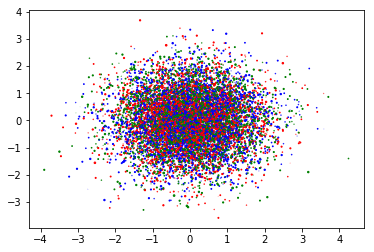

In [115]:
X = np.random.normal(0,1,fc1_pca.shape)
Y = np.random.normal(0,1,fc2_pca.shape)
Z = np.random.normal(0,1,labels_pca.shape)

plt.scatter(X,Y,Z,color=['red','blue','green'])

# t-SNE

In [99]:
fc1_embedded = TSNE(n_components=2).fit_transform(fc1)
fc1_embedded.shape

fc2_embedded = TSNE(n_components=2).fit_transform(fc2)
fc2_embedded.shape

labels_embedded = TSNE(n_components=2).fit_transform(labels)
labels_embedded.shape

(10000, 2)

/home/michela/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


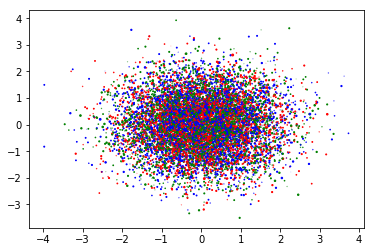

In [110]:
X = np.random.normal(0,1,fc1_embedded.shape)
Y = np.random.normal(0,1,fc2_embedded.shape)
Z = np.random.normal(0,1,labels_embedded.shape)


plt.scatter(X,Y,Z,color=['red','blue','green'])